# 1. Zusammenfassung der Analyse

* 

# 2. Loading the data

The scrapped data was in a 75MB json document containing almost 10K course details. 
The data has already been transformed and clearned. The transformation scripts generated two datasets:

* **courses_numerical_categorical_data.csv** contains non-textual fields for a typical exploratory data analysis.
* **courses_text_data.csv** contains only textual fields for NLP analysis.

As the dataset has already been cleaned and transformed there's no values missing. Some columns are the result of the processing steps, and a many fields from the original json have been removed.

In [1]:
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.2f' % x)

data_folder_path = "../data/"
file_path = data_folder_path + "courses_numerical_categorical_data.csv"

# Read csv into a panda dataframe
df = pd.read_csv(file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   udemy_id                9969 non-null   int64  
 1   title                   9969 non-null   object 
 2   instructors             9969 non-null   object 
 3   locale                  9969 non-null   object 
 4   created                 9969 non-null   object 
 5   num_subscribers         9969 non-null   int64  
 6   rating                  9969 non-null   float64
 7   num_reviews             9969 non-null   int64  
 8   num_quizzes             9969 non-null   int64  
 9   num_lectures            9969 non-null   int64  
 10  num_curriculum_items    9969 non-null   int64  
 11  category                9969 non-null   object 
 12  subcategory             9969 non-null   object 
 13  labels                  9969 non-null   object 
 14  content_length_minutes  9969 non-null   

# 3. Understanding the target variable `num_subscribers`

Our target variable is the Number of subscribers `num_subscribers`.

### 3.1 General distribution of number of subscribers 

Immediately we'll see below there are natural outliers in the data. They are not noise or input errors, but highly successful courses, therefore we'll keep them. 

In [2]:
# Create a plotly histogram of num_subscribers column in data frame
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Sort data frame by number od subscribers
df.sort_values(by='num_subscribers', ascending=False, inplace=True)

fig = make_subplots(rows=1, cols=2, shared_yaxes=True)


strip_plot = px.strip(df, y='num_subscribers', hover_data=df.columns)
violin_plot = px.violin(df, y='num_subscribers')

fig.add_trace(strip_plot['data'][0], row=1, col=1)
fig.add_trace(violin_plot['data'][0], row=1, col=2)

fig.update_layout(height=600, width=1024, title_text="Distribution of number of subscribers per course")
fig.show()


df['num_subscribers'].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

count      9969.00
mean      15308.89
std       50499.90
min          44.00
10%         395.80
20%         729.60
30%        1278.40
40%        2150.20
50%        3515.00
60%        5782.60
70%        9723.80
80%       16097.00
90%       31173.80
max     1875450.00
Name: num_subscribers, dtype: float64

### 3.2 The feeling of success

As our goal is to understand how to break into the top courses, let's have a quick look at the top 10 courses to get a feel for it, and estimate their revenue. When looking at the courses below it's impressive to see that the top 10 courses are very lucrative, with 4 of them being about Python and Data Science.

In [3]:
df_top10 = df.head(10)[['subcategory', 'title', 'num_subscribers', 'num_reviews', 'rating', 'price']]
# Calculating potential revenue for each course
df_top10['Discounted revenue (in Millions)'] = round(df_top10['num_subscribers'] * df_top10['price'] * 0.2 * 0.0000001, 2) # Adding 80% discount because Udemy courses are always on sale. This is the minimum possible revenue I'd assume.

formatted_output = df_top10.head(10).to_string(index=False)

print(formatted_output)

          subcategory                                                        title  num_subscribers  num_reviews  rating  price  Discounted revenue (in Millions)
Programming Languages     The Complete Python Bootcamp From Zero to Hero in Python          1875450       498952    4.58 199.99                              7.50
      Web Development                   The Complete 2024 Web Development Bootcamp          1219060       365816    4.70 119.99                              2.93
Programming Languages           100 Days of Code: The Complete Python Pro Bootcamp          1213974       282675    4.68 109.99                              2.67
Programming Languages            Automate the Boring Stuff with Python Programming          1120833       112019    4.65 119.99                              2.69
         Data Science  Machine Learning A-Z: AI, Python & R + ChatGPT Prize [2024]          1037484       182664    4.53 139.99                              2.90
      Web Development       

### 3.2 The distribution of number of subscribers per quantile

Analysing the numer of subscribers in quantiles by removing the top 10% (by number of subscribers) we see that the median course has a lot less subscribers (2743,5) than the highly successful ones.

In [4]:
df.sort_values(by = 'num_subscribers', ascending = False, inplace = True) 
df_distribution = df

# Calculate the 90th percentile value for the column of interest
threshold = df_distribution['num_subscribers'].quantile(0.9)

# Filter the dataframe to get the top 10%
df_90_100_percentile = df_distribution[df_distribution['num_subscribers'] >= threshold]
df_90_percentile = df_distribution[df_distribution['num_subscribers'] < threshold]

fig = px.violin(df_90_percentile, y="num_subscribers", points="all", box=True)

fig.update_layout(title_text="Spread of Number of Subscribers excluding the top 10%")
fig.show()

If we cut the dataset by deciles, and ignored the last decile (top 10%) we get a better idea how the subscribers are aggregated in each group. We see the success gets increasingly concentrated in higher deciles.

In [5]:
# Calculate quartiles and add a new column to the dataframe
df_distribution['decile'] = pd.qcut(df['num_subscribers'], q=10, labels=['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10'])

# Create a strip plot for the data in the first three quartiles
fig = px.box(df_distribution[~df_distribution['decile'].isin(['d10'])], x="num_subscribers", color="decile")

fig.update_layout(title_text="Distribution of Number of Subscribers by Decile excluding the last decile")
fig.show()

Another way to visualize this concetration is to calculate the total number of subscribers per decile plot it in a bar chart.

In [6]:
decile_sum = df_distribution.groupby('decile', observed=True)['num_subscribers'].sum()

fig = px.bar(x=decile_sum.index, y=decile_sum.values, labels={'x': 'Deciles', 'y': 'Total Num Subscribers'})
fig.update_layout(title_text="Total Number of Subscribers by Decile")
fig.show()

So now we have a clear picture how concentrated success is, let's understand what drives that success.

# 4. Why a course is successful?

Looking at the data we can outline a few hypothesis for investigation.

* Courses with more reviews will have more subscribers. There's a social proof effect 
* Courses with higher average rating will have more subscribers.
* Price category (Price bins) will influence the number of subscribers
* Time of publication will influence the number of subscribers (time to accummulate success)
* Length of curriculum & video lectures will drive up subscribers.
* Courses for beginners or intermediates will have more subscribers than for advanced.
* `num_reviews`, `num_quizzes`, `num_lectures`, `num_curriculum_items` are irrelevant for number of subscribers.
* Number of subscribers will be concentrated in just few subcategories (E.g. Data Science, Web Development, etc).
* Number of subscribers will be concentrated in just a few labels like `Python`.
* Number of subscribers will be concentrated in a few instructors (figured out the success formula, and cross-promotion)

### 4.1 Quick view on correlation to optimze hypothesis

Before we deep dive into each hypothesis, let's have a look at the correlation matrix with numerical fields to get an overview of these hypotheses and if there are any we are missing.


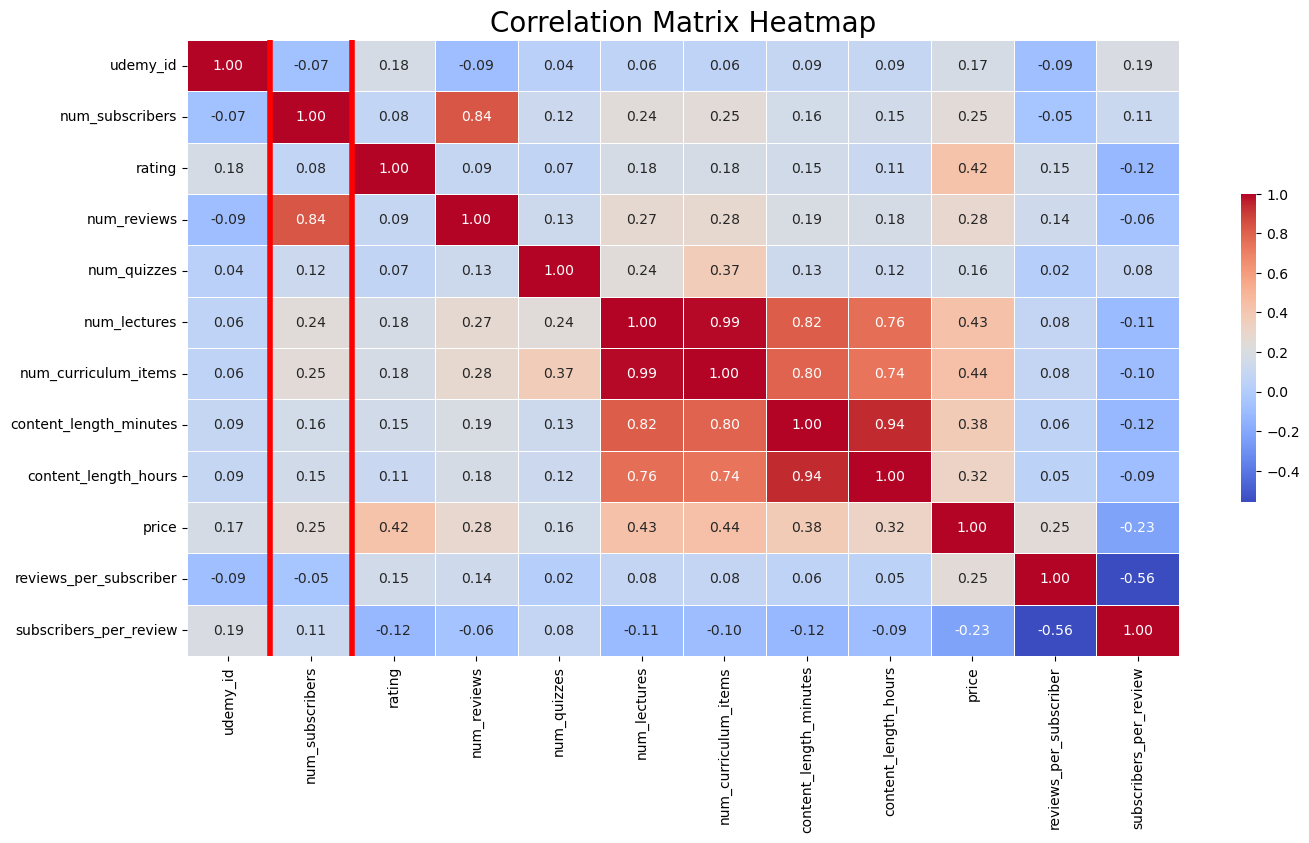

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix excluding non-numerical fields
corr_matrix = df.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(16, 8)) 
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            fmt=".2f", 
            xticklabels=corr_matrix.columns, 
            yticklabels=corr_matrix.columns,
            linewidths=.5, 
            cbar_kws={"shrink": .5})

plt.title('Correlation Matrix Heatmap', fontsize=20)
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability

# Highlighting the number of subscribers column
col_index = corr_matrix.columns.get_loc('num_subscribers')
plt.gca().axvline(col_index, color='red', linestyle='-', linewidth=4)  # Left border
plt.gca().axvline(col_index + 1, color='red', linestyle='-', linewidth=4)  # Right border

plt.show()

The only strong positive correlation we can see from this heatmap is between the number of reviews and the number of subscribers. It's understandable as Udemy prompt students to review a course early on. 

Other weak positive correlations for the number of subscribers are the number of lectures/curriculum items. Maybe students judge a course quality by how comprehensive its curriculum is, and by the reviews. 

I'm curious if the correlation changes over different deciles (in this dataset about 1000 courses) showing how a given variable changes with number of subscribers. So we can look at the correlation matrix per decile.

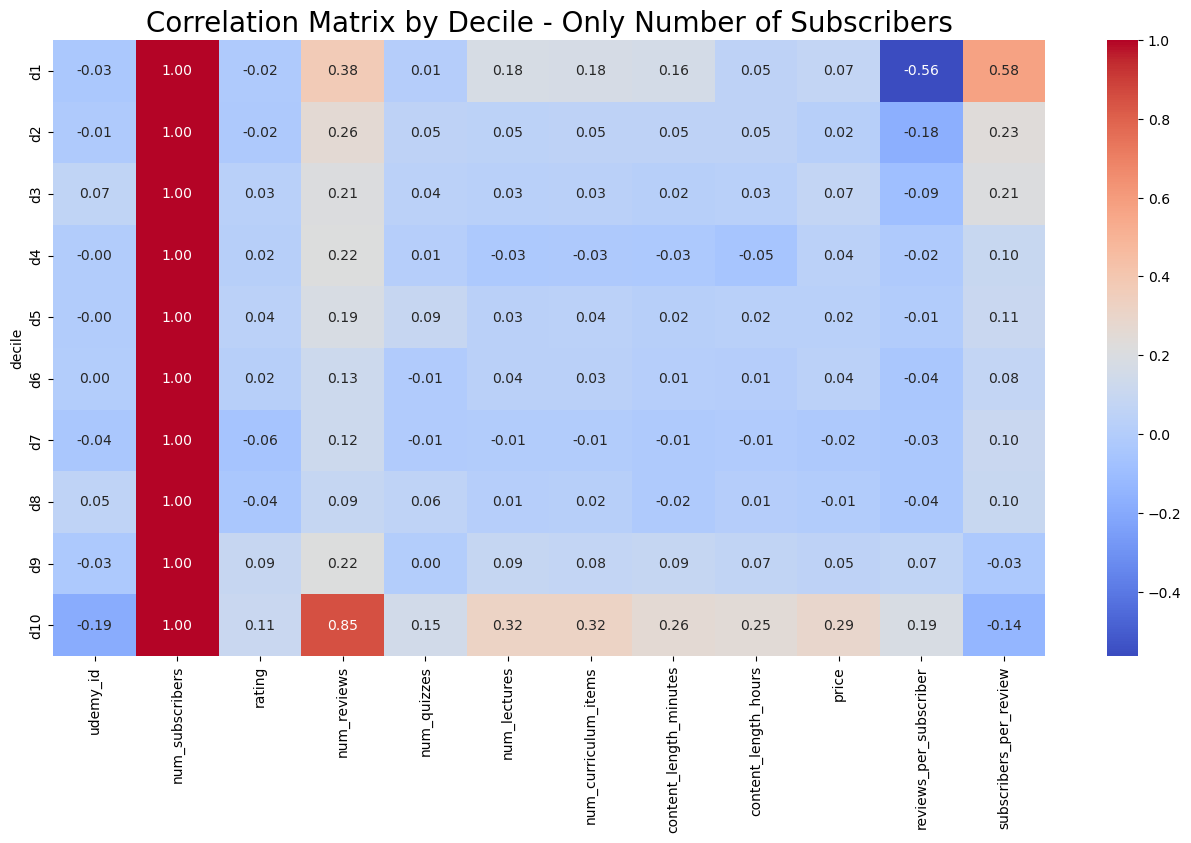

In [36]:
# Calculating the # subscribers per review to see if the ratio increases for courses with more subscribers.
df_distribution['subscribers_per_review'] = df_distribution['num_subscribers'] / df_distribution['num_reviews']

correlation_matrix_per_decile = df_distribution.groupby('decile', observed=True).corr(numeric_only=True)

plt.figure(figsize=(16, 8))
sns.heatmap(correlation_matrix_per_decile.xs('num_subscribers', level=1), 
            annot=True, 
            cmap='coolwarm', 
            fmt=".2f")
plt.title('Correlation Matrix by Decile - Only Number of Subscribers', fontsize=20)
plt.show()

---
**IDEAS**

- Understand distribution of ratings to see if there are 'lower rated' courses on udemy 
- Add caveats like recommender engine influence on course
- Understand categorical data correlation
- Are older courses more successful? (If number of reviews matters the most)
- Frequency of words in labels to find the 'data' per label
--- Create a box plot for all the labels with frequency more than...

---